In [1]:
%matplotlib notebook

In [2]:
import gpxpy
import pandas as pd
from geopy import distance 
from geopandas import GeoDataFrame
from matplotlib import pyplot as plt
from shapely.geometry import LineString

In [3]:
from dotenv import load_dotenv
_env_loaded = load_dotenv()
assert _env_loaded

In [4]:
gpx_file = open('example_orienteering_route.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

In [5]:
def transform_gpx_to_pandas(gpx: gpxpy.gpx.GPX):
    gps_track_points = []
    for track in gpx.tracks:
        print("Track:", track)
        for segment in track.segments:
            print("Segment:", segment)
            for point in segment.points:
                gps_track_point = {
                    "lon": point.longitude,
                    "lat": point.latitude,
                    "timestamp": point.time,
                    "height": point.elevation
                }
                gps_track_points.append(gps_track_point)
                # print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

    gps_track_points_df= pd.DataFrame(gps_track_points)
    gps_track_points_df['timestamp'] = pd.to_datetime(gps_track_points_df['timestamp'])
    return gps_track_points_df

In [6]:
gpx_data_frame = transform_gpx_to_pandas(gpx)

Track: GPXTrack(name='Vihti Running', segments=[GPXTrackSegment(points=[...])])
Segment: GPXTrackSegment(points=[...])


In [7]:
gpx_data_frame.max() - gpx_data_frame.min()

lon                 0.019149
lat                 0.011436
timestamp    0 days 00:44:09
height             10.600006
dtype: object

In [8]:
gpx_data_frame['timestamp'].dtype

datetime64[ns, SimpleTZ("Z")]

In [9]:
def add_distance_and_time_from_last(df):
    distances_from_last = []
    seconds_from_last = []
    geometries = []
    
    distances_from_last.append(0)
    seconds_from_last.append(0)
    geometries.append(None)
    
    for i in range(len(df) - 1):
        prev_gps_point = df.iloc[i]
        gps_point = df.iloc[i+1]
        
        prev_coords = prev_gps_point.lon, prev_gps_point.lat
        coords = gps_point.lon, gps_point.lat
        
        dt_from_last = gps_point.timestamp - prev_gps_point.timestamp
        seconds = dt_from_last.total_seconds()
        seconds_from_last.append(seconds)
        
        distance_from_prev = distance.distance(prev_coords, coords).m
        distances_from_last.append(distance_from_prev)
        
        geometry = LineString([prev_coords, coords])
        geometries.append(geometry)
        
    
    df['seconds'] = seconds_from_last
    df['distance'] = distances_from_last
    df['geometry'] = geometries
    df = GeoDataFrame(df, geometry='geometry')
    return df

gpx_data_frame = add_distance_and_time_from_last(gpx_data_frame)

/home/rmkujala/miniconda3/envs/gps-analysis/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<IPython.core.display.Javascript object>


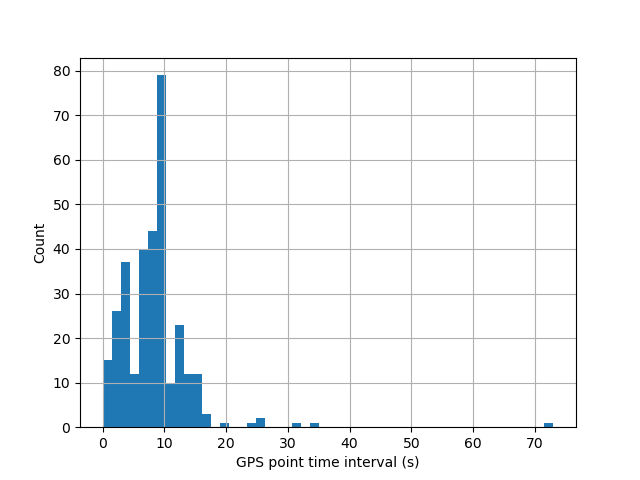

Text(0, 0.5, 'Count')

In [10]:
plt.figure()
gpx_data_frame['seconds'].hist(bins=50)
plt.xlabel("GPS point time interval (s)")
plt.ylabel("Count")

<IPython.core.display.Javascript object>


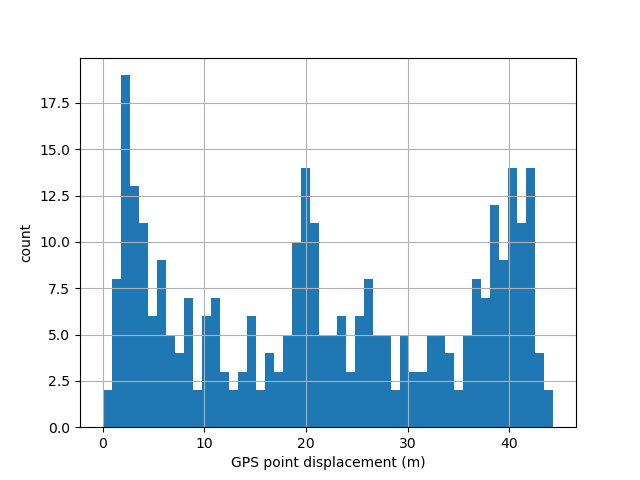

Text(0, 0.5, 'count')

In [11]:
plt.figure()
gpx_data_frame['distance'].hist(bins=50)
plt.xlabel("GPS point displacement (m)")
plt.ylabel("count")

In [12]:
gpx_data_frame['seconds_per_meter'] = gpx_data_frame['seconds'] / gpx_data_frame['distance']

<IPython.core.display.Javascript object>


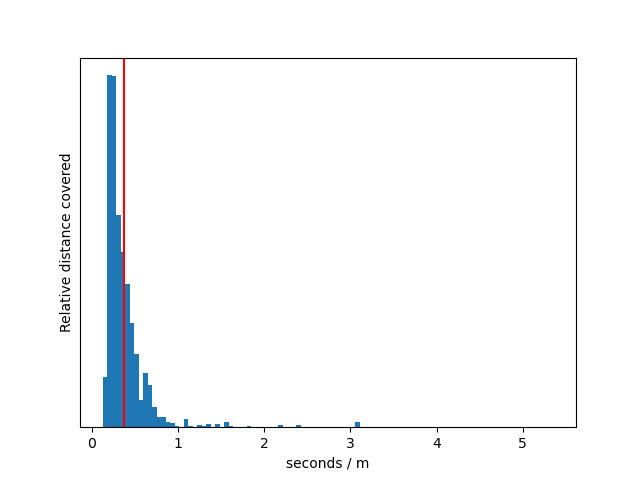

mean_min_per_km = 6.252867487829438


In [13]:
plt.figure()
plt.hist(gpx_data_frame['seconds_per_meter'], bins=100, weights=gpx_data_frame['distance'])
mean_s_per_m = sum(gpx_data_frame['seconds_per_meter'].iloc[1:] * gpx_data_frame['distance'].iloc[1:]) / sum(gpx_data_frame['distance'].iloc[1:])
plt.xlabel("seconds / m")
plt.ylabel("Relative distance covered")
plt.axvline(mean_s_per_m, color="red")
plt.yticks([])
print(f"mean_min_per_km = {mean_s_per_m / 60. * 1000}")

In [14]:
def plot_gpx(ax, gpx_data_frame, x="lat", y="lon", lw_column="seconds_per_meter", lw_multiplier=1):
    
    for i, row in gpx_data_frame.iterrows():

        if row.geometry is not None:
            x = row.geometry.xy[0]
            y = row.geometry.xy[1]
            
            if lw_column is not None:
                lw = row[lw_column] 
            else:
                lw = 1
            lw = lw * lw_multiplier
            
            ax.plot(x, y, 
                    lw=lw,
                    color="red", 
                    alpha=0.5, 
                    solid_capstyle="butt")

<IPython.core.display.Javascript object>


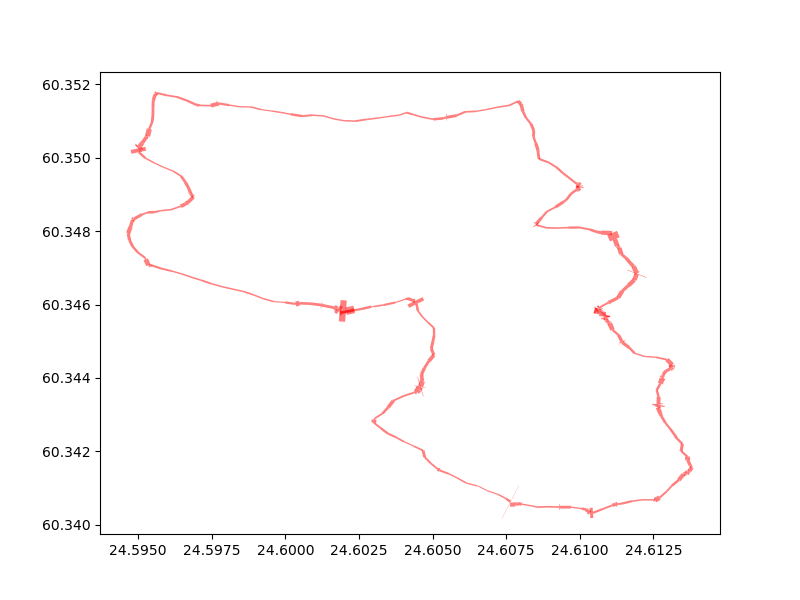

In [15]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_gpx(ax, gpx_data_frame, lw_column='seconds_per_meter', lw_multiplier=5)

# Test out same visualization using pydeck:

In [16]:
import pydeck

In [17]:
medians = gpx_data_frame.median()
mins = gpx_data_frame.min()
maxs = gpx_data_frame.max()

/home/rmkujala/miniconda3/envs/gps-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
/home/rmkujala/miniconda3/envs/gps-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/home/rmkujala/miniconda3/envs/gps-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/home/rmkujala/miniconda3/envs/gps

In [18]:
def extract_path(row):
    xs, ys = row.geometry.xy
    lonlats = list(zip(xs, ys)) # xs,ys))
    return lonlats

gpx_data_frame = gpx_data_frame.dropna()
paths = []
for i, row in gpx_data_frame.iterrows():
    path = extract_path(row)
    paths.append(path)
gpx_data_frame["path"] = paths

In [27]:
initial_view_state = pydeck.ViewState(latitude=medians.lat, 
                                      longitude=medians.lon, 
                                      zoom=14, 
                                      max_zoom=16, 
                                      bearing=0)

In [28]:
path_layer = pydeck.Layer(
    type="PathLayer", 
    data=gpx_data_frame,
    pickable=True,
    get_color=[255, 0, 0],
    width_scale=10,
    width_min_pixels=1,
    get_path="path",
    get_width="seconds_per_meter")

In [29]:
r = pydeck.Deck(initial_view_state=initial_view_state, map_style="light", layers=[path_layer])
r

{"initialViewState": {"bearing": 0, "latitude": 60.3460525162518, "longitude": 24.606303325854242, "maxZoom": 16, "zoom": 14}, "layers": [{"@@type": "PathLayer", "data": [{"distance": 20.136996568836512, "geometry": {"coordinates": [[24.607632150873542, 60.34054619260132], [24.607813451439142, 60.34056086093187]], "type": "LineString"}, "height": 103.0, "lat": 60.34056086093187, "lon": 24.607813451439142, "path": [[24.607632150873542, 60.34054619260132], [24.607813451439142, 60.34056086093187]], "seconds": 12.0, "seconds_per_meter": 0.5959180634996425, "timestamp": {}}, {"distance": 4.6837975990854925, "geometry": {"coordinates": [[24.607813451439142, 60.34056086093187], [24.607854271307588, 60.34057293087244]], "type": "LineString"}, "height": 103.0, "lat": 60.34057293087244, "lon": 24.607854271307588, "path": [[24.607813451439142, 60.34056086093187], [24.607854271307588, 60.34057293087244]], "seconds": 2.0, "seconds_per_meter": 0.42700393381441126, "timestamp": {}}, {"distance": 3.5370725269942613, "geometry": {"coordinates": [[24.607854271307588, 60.34057293087244], [24.607885871082544, 60.34057796001434]], "type": "LineString"}, "height": 103.0, "lat": 60.34057796001434, "lon": 24.607885871082544, "path": [[24.607854271307588, 60.34057293087244], [24.607885871082544, 60.34057796001434]], "seconds": 2.0, "seconds_per_meter": 0.5654393526670382, "timestamp": {}}, {"distance": 15.32439976597126, "geometry": {"coordinates": [[24.607885871082544, 60.34057796001434], [24.608023753389716, 60.34056555479765]], "type": "LineString"}, "height": 103.0, "lat": 60.34056555479765, "lon": 24.608023753389716, "path": [[24.607885871082544, 60.34057796001434], [24.608023753389716, 60.34056555479765]], "seconds": 7.0, "seconds_per_meter": 0.4567878746901341, "timestamp": {}}, {"distance": 39.38087114727807, "geometry": {"coordinates": [[24.608023753389716, 60.34056555479765], [24.608376463875175, 60.34051668830216]], "type": "LineString"}, "height": 103.0, "lat": 60.34051668830216, "lon": 24.608376463875175, "path": [[24.608023753389716, 60.34056555479765], [24.608376463875175, 60.34051668830216]], "seconds": 8.0, "seconds_per_meter": 0.20314431263039603, "timestamp": {}}, {"distance": 19.323541874313364, "geometry": {"coordinates": [[24.608376463875175, 60.34051668830216], [24.608548376709223, 60.340484250336885]], "type": "LineString"}, "height": 103.0, "lat": 60.340484250336885, "lon": 24.608548376709223, "path": [[24.608376463875175, 60.34051668830216], [24.608548376709223, 60.340484250336885]], "seconds": 4.0, "seconds_per_meter": 0.20700138856620118, "timestamp": {}}, {"distance": 41.10707332567351, "geometry": {"coordinates": [[24.608548376709223, 60.340484250336885], [24.608919359743595, 60.340494979172945]], "type": "LineString"}, "height": 102.80000305175781, "lat": 60.340494979172945, "lon": 24.608919359743595, "path": [[24.608548376709223, 60.340484250336885], [24.608919359743595, 60.340494979172945]], "seconds": 10.0, "seconds_per_meter": 0.24326713606620295, "timestamp": {}}, {"distance": 41.88358760953816, "geometry": {"coordinates": [[24.608919359743595, 60.340494979172945], [24.60929738357663, 60.34048550762236]], "type": "LineString"}, "height": 102.80000305175781, "lat": 60.34048550762236, "lon": 24.60929738357663, "path": [[24.608919359743595, 60.340494979172945], [24.60929738357663, 60.34048550762236]], "seconds": 10.0, "seconds_per_meter": 0.2387570065206806, "timestamp": {}}, {"distance": 2.3909751368498933, "geometry": {"coordinates": [[24.60929738357663, 60.34048550762236], [24.609318925067782, 60.34048399887979]], "type": "LineString"}, "height": 102.80000305175781, "lat": 60.34048399887979, "lon": 24.609318925067782, "path": [[24.60929738357663, 60.34048550762236], [24.609318925067782, 60.34048399887979]], "seconds": 2.0, "seconds_per_meter": 0.8364787944365651, "timestamp": {}}, {"distance": 42.10483878650948, "geometry": {"coordinates": [[24.609318925067782, 60.34048399887979], [24.60969904437661, 60.340482993051